In [4]:
from kagglehub import KaggleDatasetAdapter
import os
import kagglehub
import pandas as pd

# Download latest version
data = (kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "armitaraz/chatgpt-reddit",
    "chatgpt-reddit-comments.csv")
        .dropna())

data.tail()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
52410,16667,j4lbiix,t1_j4kgcac,"Scary thing is, in this future text won’t be t...",r/technology
52411,16668,j5m0v6m,t3_10jmvpj,"Read the T.O.S., you'll thank me later",r/technology
52412,16669,j5m6aj0,t1_j5m0v6m,What am I missing here... https://openai.com/t...,r/technology
52413,16670,j5nylax,t1_j5m0v6m,What does ChatGTP think of its own TOS?,r/technology
52414,16671,j5mwpdr,t1_j5m6aj0,Don't know what they're referring to in the TO...,r/technology


In [5]:
docs = data["comment_body"]
categories = data["subreddit"]

In [6]:
from narrativegraphs import CooccurrenceGraph
from narrativegraphs.nlp.tuplets.cooccurrences import DocumentCooccurrenceExtractor

if os.path.exists("chatgpt_reddit.db"):
    model = CooccurrenceGraph.load("chatgpt_reddit.db")
else:
    model = CooccurrenceGraph(
        cooccurrence_extractor=DocumentCooccurrenceExtractor(),
        sqlite_db_path="chatgpt_reddit.db",
        on_existing_db="overwrite"
    ).fit(docs)

INFO:narrativegraphs.pipeline:Adding 52412 documents to database
INFO:narrativegraphs.pipeline:Extracting entities
Extracting entities: 100%|██████████| 52412/52412 [01:42<00:00, 509.75it/s] 
INFO:narrativegraphs.pipeline:Resolving entities
INFO:narrativegraphs.pipeline:Mapping tuplets
INFO:narrativegraphs.pipeline:Calculating stats


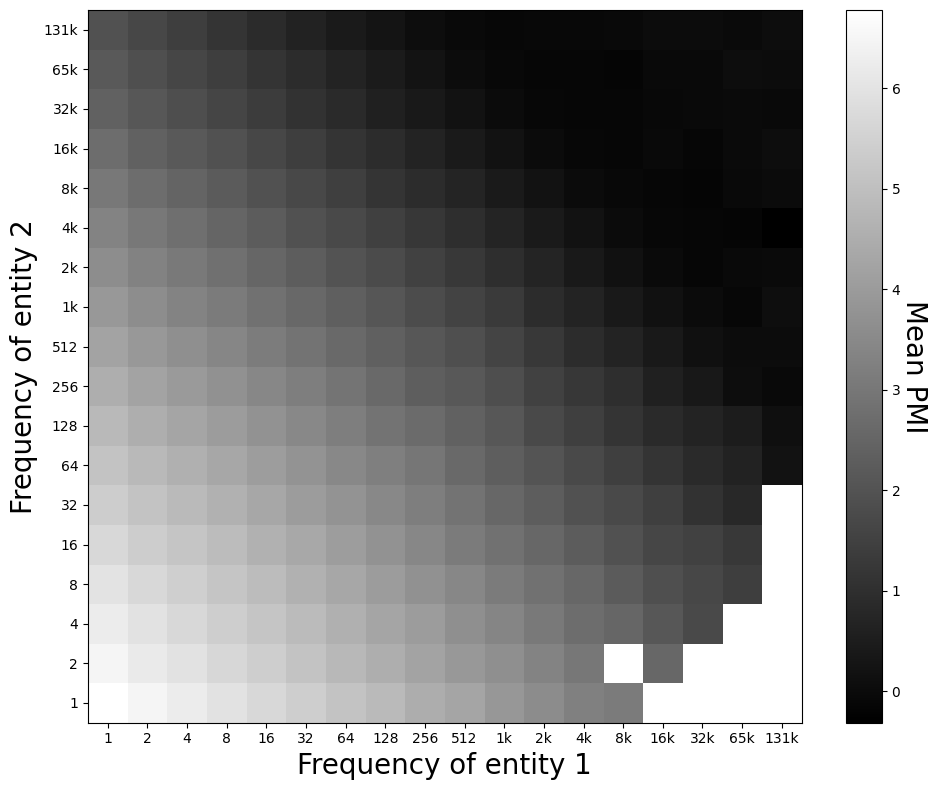

In [7]:
from sharedutils import visualize_pmi_by_frequency

visualize_pmi_by_frequency(model.cooccurrences_)

In [17]:
from narrativegraphs import GraphFilter

graph_filter = GraphFilter(
    minimum_edge_frequency=2,
    maximum_edge_doc_frequency=100,
    minimum_node_frequency=5,
    maximum_node_frequency=100
)

In [18]:
comms = model.graph.find_communities(
    graph_filter=graph_filter,
    min_weight=2,
    community_detection_method_args=dict(k=3)
)
for comm in sorted(comms, key=lambda c: c.score, reverse=True):
    if len(comm.members) < 2: continue
    print(*[e.label for e in comm.members], sep=", ")
    print()

a lollipop, Mr. T, the A-Team

CTF, Unreal, Quake I, "breadcrumb paths

pelican, a serious and stigmatized disease, Fred  
, a limerick

Biological sex, a diff topic, all males

Mel Blanc, Looney Toons, Bugs Bunny

definite answers, its best efforts, sexually explicit, immoral, illegal, harmful or dangerous answers, an unconstrained answer, this hypothetical scenario

certain industries, the exact extent, many tasks, college-educated workers, Some displacement

just an educated guess, an alternative explanation, a random place, latent space, a suitable response, the final result, a new seed, new places, generic answers

other departments, several meetings, an internal memo, audio recording

a  Desktop, Star  Wars level droids, larger quantities, SayCan

900,000 for $, bypass scripts, a fuss, 900,000 credits

the same content, ---
^, Beep boop, Bad bot'/'Good, Toldry/RedditAutoCrosspostBot

self-serving influence, one aspect, incorrect or inappropriate responses

your registry, error co

In [10]:
comms = model.graph.find_communities(
    graph_filter=graph_filter,
    community_detection_method="louvain",
    min_weight=2,
    community_detection_method_args=dict(resolution=5)
)
for comm in sorted(comms, key=lambda c: c.score, reverse=True):
    if len(comm.members) < 2: continue
    print(*[e.label for e in comm.members], sep=", ")
    print()

a rat, Dad

the ocean, Idk

its merits, Essay writing

costumer service, a ticket

Khan, Senior Reporter

my telegram, GPT

a perfect thing, Reply

modern solutions, Problem

interesting products, Googles

stupid answers, Quests

single protein, decade

Fitzgerald, green light

System, a good or bad decision

CAP, Your challenge

the subject, individual practice

an open book assignment, Nots

just the tip, an iceberg

their predictions, a final prediction, new tasks

significant contributions, a sport

some goal, more natural seeming

Hard work, BsC

drive thrus, MN

a very limited version, surprise beers

long term, Short term

perfect scores, a long enough paper

These conditions, the absence

your fingers, big leaps, energy technology

a net benefit, miss information prevention

porn making, Sex workers

Razor, Occam, confounding variables

the mushrooms, this particular mushroom

their nuances, social situations

Our mission, artificial general intelligence benefits

performance r

In [ ]:
# create server to be viewed in own browser which blocks execution of other cells
model.serve_visualizer()